In [10]:
import math
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec, ticker

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

In [11]:
SCORES_FILE = "../../results/shaping-eval/tamaraw/scores.csv"
OUTPUT_FILE = pathlib.Path("/tmp/plot.png")
MIN_PKT_SIZE = 0
WITH_LEGEND = True
YLABELS_AT = 0.25

if "snakemake" in globals():
    SCORES_FILE = snakemake.input[0]
    OUTPUT_FILE = pathlib.Path(snakemake.output[0])
    MIN_PKT_SIZE = snakemake.params.get("min_pkt_size", MIN_PKT_SIZE)
    WITH_LEGEND = snakemake.params.get("with_legend", WITH_LEGEND)
    YLABELS_AT = snakemake.params.get("ylabels_at", YLABELS_AT)

In [12]:
data = pd.melt(pd.read_csv(SCORES_FILE), id_vars=["sample", "rate", "dir", "min_pkt_size"], var_name="metric")
data = data[data["min_pkt_size"] == MIN_PKT_SIZE]
data

,sample,rate,dir,min_pkt_size,metric,value
0,results/shaping-eval/tamaraw/dataset/0000/0_0,1ms,in,0,pearsonr,0.119070
2,results/shaping-eval/tamaraw/dataset/0000/0_0,1ms,out,0,pearsonr,-0.036511
4,results/shaping-eval/tamaraw/dataset/0000/0_0,5ms,in,0,pearsonr,0.633462
6,results/shaping-eval/tamaraw/dataset/0000/0_0,5ms,out,0,pearsonr,0.323084
8,results/shaping-eval/tamaraw/dataset/0000/0_0,25ms,in,0,pearsonr,0.906700
...,...,...,...,...,...,...
31990,results/shaping-eval/tamaraw/dataset/0789/1_0,5ms,out,0,euclidean,0.409733
31992,results/shaping-eval/tamaraw/dataset/0789/1_0,25ms,in,0,euclidean,0.879033
31994,results/shaping-eval/tamaraw/dataset/0789/1_0,25ms,out,0,euclidean,0.334935
31996,results/shaping-eval/tamaraw/dataset/0789/1_0,50ms,in,0,euclidean,0.878312


In [13]:
RATE_COL = "Sampling rate (ms)"

plot_data = data.rename(columns={
    "dir": "Direction",
    "rate": RATE_COL,
    "value": "Score",
})
plot_data.loc[:, "Direction"] = plot_data["Direction"].replace({
    "in": "Server → Client", 
    "out": "Client → Server",
})
plot_data[RATE_COL] = plot_data[RATE_COL].apply(lambda x: int(x[:-2]))

plot_data

,sample,Sampling rate (ms),Direction,min_pkt_size,metric,Score
0,results/shaping-eval/tamaraw/dataset/0000/0_0,1,Server → Client,0,pearsonr,0.119070
2,results/shaping-eval/tamaraw/dataset/0000/0_0,1,Client → Server,0,pearsonr,-0.036511
4,results/shaping-eval/tamaraw/dataset/0000/0_0,5,Server → Client,0,pearsonr,0.633462
6,results/shaping-eval/tamaraw/dataset/0000/0_0,5,Client → Server,0,pearsonr,0.323084
8,results/shaping-eval/tamaraw/dataset/0000/0_0,25,Server → Client,0,pearsonr,0.906700
...,...,...,...,...,...,...
31990,results/shaping-eval/tamaraw/dataset/0789/1_0,5,Client → Server,0,euclidean,0.409733
31992,results/shaping-eval/tamaraw/dataset/0789/1_0,25,Server → Client,0,euclidean,0.879033
31994,results/shaping-eval/tamaraw/dataset/0789/1_0,25,Client → Server,0,euclidean,0.334935
31996,results/shaping-eval/tamaraw/dataset/0789/1_0,50,Server → Client,0,euclidean,0.878312


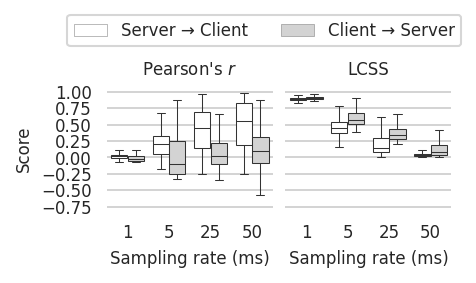

In [28]:
metric_label = {
    "pearsonr": "Pearson's $r$", 
    "spearmanr": "Spearman's $\\rho{}$",
    "lcss": "LCSS",
    "euclidean": "Scaled Euclidean"
}

def plot(data):
    fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(3.5 * .9, 1.8 * .9), squeeze=False, dpi=150)
    # display(data.groupby(["metric", "Direction", RATE_COL]).median())
    
    ylim_bottom = 0
    for metric, ax in zip(["pearsonr", "lcss"], axes.ravel()):
        c = "#333333"
        sns.boxplot(
            data=data[data["metric"] == metric], x=RATE_COL, y="Score", hue="Direction",
            showfliers=False, ax=ax, linewidth=0.5, palette=["white", "lightgrey"],
            boxprops=dict(edgecolor=c),
            whiskerprops=dict(color=c),
            capprops=dict(color=c),
            medianprops=dict(color=c),
        )
        
        ax.set_title(metric_label[metric])
        # ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.get_legend().remove()
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(YLABELS_AT))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
        ax.grid(True, axis="y", which="both")
        
        ylim_bottom = min(ylim_bottom, math.floor(ax.get_ylim()[0] * 4) / 4)
        
    axes[0][0].set_ylabel("Score")
    ax.set_ylim(ylim_bottom * 1.05)
    
    # Format the axes spacing
    # Must come before the addition of the 
    sns.despine(left=True, bottom=True)
    fig.tight_layout(w_pad=.75)
    fig.subplots_adjust(wspace=None, hspace=None)
        
    # Use a large, hidden axis to set a common x-axis label
    # meta_ax = fig.add_subplot(111, frameon=False)
    # meta_ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # meta_ax.xaxis.set_major_locator(ticker.NullLocator())
    # meta_ax.yaxis.set_major_locator(ticker.NullLocator())
    # meta_ax.grid(False, which="both", axis="both")
    # meta_ax.set_xlabel(RATE_COL, labelpad=20)
    
    if WITH_LEGEND:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1.15), ncol=2)
        
    return fig

fig = plot(plot_data)
fig.savefig(OUTPUT_FILE.with_suffix(".png"), bbox_inches="tight", dpi=150)
fig.savefig(OUTPUT_FILE.with_suffix(".pgf"), backend="pgf", bbox_inches="tight")